In [1]:
import arviz as az
import corner
import cornerhex

import optax

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import pandas as pd

import json as js
    
from snuddd.jinterp import interp1d

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" 
from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

In [3]:
import tqdm.utils
def ssl(x):
    return 150, 200
tqdm.utils._screen_shape_linux = ssl

In [4]:
from snuddd import config
from snuddd.targets import Nucleus, electron_xe, Electron
from snuddd.models import GeneralNSI

import numpyro
from numpyro import optim
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro import infer
from numpyro.infer import MCMC, NUTS, autoguide, reparam

2024-05-19 08:52:35.129045: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.2 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
import jax.numpy as jnp

In [6]:
from scipy.optimize import root

In [7]:
Xe_nucleus = Nucleus(54, 132, mass=131.9041535 * config.u)

In [8]:
SM_matrix = np.array([[0, 0, 0],
                      [0, 0, 0],
                      [0, 0, 0]])

SM_eta = 0
SM_phi = 0

sm_model = GeneralNSI(SM_matrix, SM_eta, SM_phi)

In [9]:
Xe_nucleus.update_model(sm_model)
Xe_nucleus.prepare_density()

In [10]:
E_Rs = np.logspace(-1, 1, 100) / 1e6 # Recoil Energy in GeV 

sm_spec=Xe_nucleus.spectrum(E_Rs, nu = '8B')

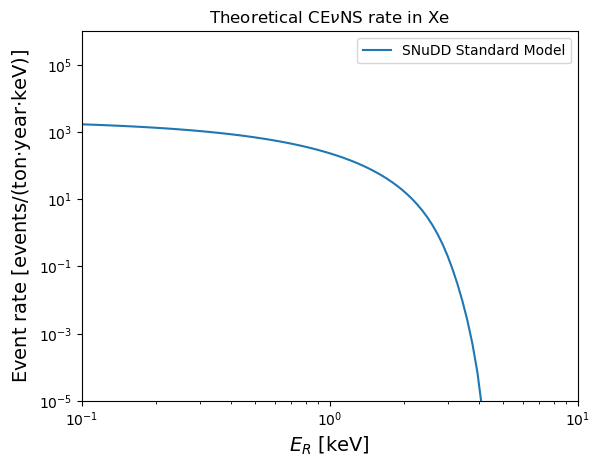

In [11]:
plt.loglog(E_Rs*1e6, abs(sm_spec), label="SNuDD Standard Model") # abs because of the residual imaginary part from the density matrix. All elements have zero imaginary part anyway.
plt.legend()
plt.title(r"Theoretical CE$\nu$NS rate in Xe")
plt.ylabel(r'${\rm d}R/{\rm d}E_R\,\,\left[{\rm ton}^{-1}\,{\rm yr}^{-1}\,{\rm keV}^{-1}\right]$', size=14)
plt.xlabel(r'$E_{R}\,\,\left[{\rm keV}\right]$', size=14)

plt.ylabel(r"Event rate [events/(ton$\cdot$year$\cdot$keV)]")

plt.xlim(xmin=1e-1, xmax=1e1)
plt.ylim(ymax=1e6, ymin=1e-5)

plt.show()

In [12]:
""" IN SI UNIT """
""" Reduced Planck Constant in J·s """
HBAR = 1.054571800E-34
""" Speed of Light in m/s """
C = 2.99792458E8
""" Avogaro's Number in 1/mol """
A_V = 6.022140857E23
""" Charge of Electron in C """
CH_E = 1.6021766208E-19

""" keV in J """
KEV = 1e3 * CH_E
""" GeV in J """
GEV = 1e9 * CH_E

GeV = 1.0
MeV = GeV / 1e3
keV = GeV / 1e6
eV = GeV / 1e9

# GeV ^ -1
m = 1.0 / (HBAR * C / GEV) / GeV
cm = m / 1e2
km = m * 1e3
mm = m / 1e3
um = m / 1e6
nm = m / 1e9
pm = m / 1e12
fm = m / 1e15

# GeV
kg = 1.0 * C**2 / GEV * GeV
ton = kg * 1e3
g = kg * 1e-3

# GeV ^ -1
sec = 1.0 * C * m
dy = 24.0 * 3600.0 * sec
yr = 365.0 * dy

# Fermi's const
Gf = 1.1663787e-5 / GeV**2

# Neutron mass
mn = 0.9314940954 * GeV

# Mixing angle
sin2the = 0.2223

In [13]:
NSI_matrix = np.array([[0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0]])

NSI_eta = 0
NSI_phi = 0

NSI_model = GeneralNSI(NSI_matrix, NSI_eta, NSI_phi)

Xe_nucleus.update_model(NSI_model)
Xe_nucleus.prepare_density()

NSI_spec=Xe_nucleus.spectrum(E_Rs, nu = '8B')

acc_data = pd.read_csv('acceptance.csv').drop(columns='Unnamed: 0')

accept = np.array(acc_data['acceptance'])
energy = np.array(acc_data['energy'] * keV)
accept = interp1d(energy, accept)

In [14]:
Xe_electron = Electron(Xe_nucleus, None, None)
Xe_electron.update_model(NSI_model)
Xe_electron.prepare_density()

In [16]:
er = energy
tot_rate = (np.abs(Xe_nucleus.spectrum(er, nu = '8B')) * accept(er).astype("float64") * (yr**(-1) * keV**(-1) * ton**(-1)))

delta_energy = er[1] - er[0]
total_rate = np.sum(tot_rate) * delta_energy
upper_lim_B8_flux = 5.25e6 * 2.3 * cm**-2 * sec**-1
lower_lim_B8_flux = 5.25e6 * 0.9 * cm**-2 * sec**-1
tot_flux = 5.46e6 * cm**-2 * sec**-1
upper_lim_total_rate = total_rate / tot_flux * upper_lim_B8_flux
lower_lim_total_rate = total_rate / tot_flux * lower_lim_B8_flux
print("{:} {:.2f} per ty".format("90% UL B8 solar neutrino rate:", upper_lim_total_rate / (yr**(-1) * ton**(-1))))

90% UL B8 solar neutrino rate: 13.12 per ty


In [17]:
pp_10kev = jnp.real(Xe_electron.spectrum(np.array([1.0e-5]), nu = 'pp'))

In [18]:
pp_10kev

Array(2.90227542, dtype=float64)

In [19]:
er_energies = np.linspace(24, 50, 27)

In [20]:
# %%timeit
pp_sum = jnp.real(jnp.sum(Xe_electron.spectrum(er_energies, nu = 'pp')))

In [21]:
pp_sum

Array(1.78203524, dtype=float64)

In [22]:
jnp.sum(jnp.abs(Xe_nucleus.spectrum(er, nu = '8B')) * accept(er) * (yr**(-1) * keV**(-1) * ton**(-1))) * delta_energy * 0.6 * ton * yr + 5.38

Array(8.93911392, dtype=float64)

In [23]:
import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer
from numpyro import handlers

def nsi_rate(rate = None):
    eps_ee = numpyro.sample("eps_ee", dist.Uniform(-5.0, 5.0))
    eps_em = numpyro.sample("eps_em", dist.Uniform(-5.0, 5.0))
    eps_et = numpyro.sample("eps_et", dist.Uniform(-5.0, 5.0))
    eps_mm = numpyro.sample("eps_mm", dist.Uniform(-5.0, 5.0))
    eps_mt = numpyro.sample("eps_mt", dist.Uniform(-5.0, 5.0))
    eps_tt = numpyro.sample("eps_tt", dist.Uniform(-5.0, 5.0))
    sineta = numpyro.sample("sineta", dist.Uniform(-1., 1.))
    phi = numpyro.sample("phi", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    
    NSI_matrix = jnp.asarray([[eps_ee, eps_em, eps_et],
                       [eps_em, eps_mm, eps_mt],
                       [eps_et, eps_mt, eps_tt]])
    NSI_eta = jnp.arcsin(sineta)
    NSI_phi = phi

    NSI_model = GeneralNSI(NSI_matrix, NSI_eta, NSI_phi)
    Xe_nucleus.update_model(NSI_model)
    Xe_nucleus.prepare_density()

    tot_rate = jnp.sum(jnp.abs(Xe_nucleus.spectrum(er, nu = '8B')) * accept(er) * (yr**(-1) * keV**(-1) * ton**(-1))) * delta_energy
    tot_lambda = tot_rate * 0.6 * ton * yr + 5.38
    
    Xe_electron.update_model(NSI_model)
    Xe_electron.prepare_density()
    pp_sum_NSI = jnp.real(jnp.sum(Xe_electron.spectrum(er_energies, nu = 'pp')))
    
    measured_pp_ratio = numpyro.sample("measured_pp_ratio", dist.TruncatedNormal(1.72, 1.72, low=0.0), obs=pp_sum_NSI/pp_sum)
    
    
    numpyro.sample("rate", dist.Poisson(tot_lambda), obs=rate)

    

In [24]:
sampler = infer.MCMC(
    infer.NUTS(nsi_rate, step_size=5e-1, adapt_step_size=False),
    num_warmup=200,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
    chain_method='sequential'
)

In [28]:

%time sampler.run(jax.random.PRNGKey(0), rate = 6)

/home/juehang/.conda/envs/numpyro_gpu/lib/python3.11/site-packages/jax/_src/lax/lax.py:2652: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
warmup:   5%| | 112/2200 [00:26<08:05,  4.30it/s, 127 steps of size 5.00e-01. ac


KeyboardInterrupt: 

In [ ]:
sampler.print_summary()
samples_1 = sampler.get_samples()

In [ ]:
samples_array = np.vstack([samples_1[key] for key in samples_1])
fig = corner.corner(samples_array.T, labels=list(samples_1.keys()), quantiles=[0.16, 0.5, 0.84], show_titles=True)

# Show the plot
fig.show()


In [199]:
guide = autoguide.AutoBNAFNormal(
    nsi_rate,
    hidden_factors=[10, 10],
    num_flows=3
    )

# guide = autoguide.AutoIAFNormal(
#     nsi_rate,
#     hidden_dims=[30,30],
#     num_flows=5
# )

# guide = autoguide.AutoNormal(nsi_rate)


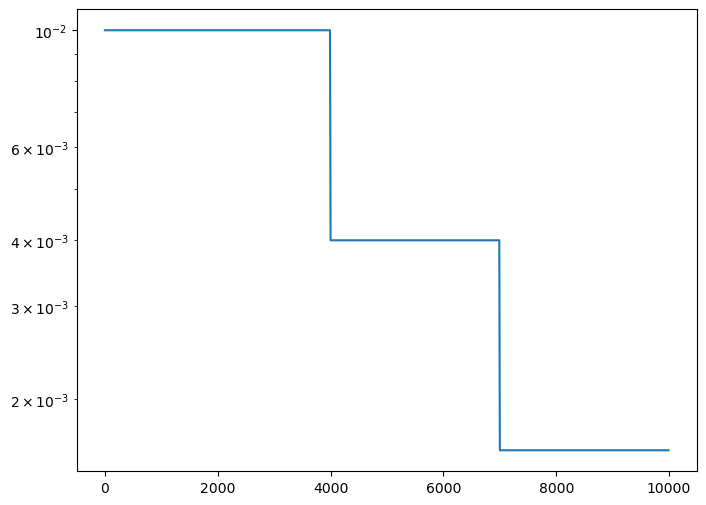

In [269]:
N_1 = 4000
N_2 = 3000
N_3 = 3000
epochs = N_1 + N_2 + N_3
high_lr = 1e-2
lr_multiplier = 0.4
# schedule = optax.join_schedules([optax.cosine_decay_schedule(high_lr, N_1, alpha=lr_multiplier), optax.cosine_decay_schedule(high_lr, N_2, alpha=lr_multiplier)], [N_1])
# schedule = optax.join_schedules([optax.constant_schedule(high_lr), optax.cosine_decay_schedule(high_lr, N_2, alpha=lr_multiplier)], [N_1])
schedule = optax.join_schedules([optax.constant_schedule(high_lr), optax.constant_schedule(high_lr*lr_multiplier), optax.constant_schedule(high_lr*lr_multiplier**2)], [N_1, N_1+N_2])
x = np.arange(0, epochs, 10)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(
    x,
    [schedule(i) for i in x],
)
ax.set(yscale='log')
plt.show()

In [270]:
svi = infer.SVI(nsi_rate, guide, optax.adamw(schedule), infer.Trace_ELBO(num_particles=30))
# svi = infer.SVI(nsi_rate, guide, optax.adamw(schedule), infer.TraceGraph_ELBO(num_particles=30))

## BNAF experiments

| Hidden factors | Flows | [1-250] loss | [251-500] loss | [501-750] loss | [751-1000] loss | [1001-1250] loss | [1251-1500] loss |
| -------------- | ----- | ------------ | -------------- | -------------- | --------------- | ---------------- | ---------------- |
| 4              | 3     | 15.8143      | 11.2809        | 10.8140        | 10.6976         | 10.6012          | 10.5826          |
| 6              | 3     | 15.0922      | 11.3197        | 10.8067        | 10.6796         | 10.6290          | 10.5792          |
| 8              | 3     | 14.8084      | 11.4154        | 10.8938        | 10.7292         | 10.6589          | 10.6063          |
| 10             | 3     | 18.5412      | 12.4175        | 11.4963        | 11.0965         | 10.8564          | 10.7603          |
| 12             | 3     | 18.7777      | 12.7962        | 11.7383        | 11.2573         | 10.9734          | 10.8183          |
| 4              | 4     | 16.4520      | 11.6841        | 11.0162        | 10.8440         | 10.7294          | 10.6383          |
| 6              | 4     | 15.9908      | 11.6549        | 11.0074        | 10.8549         | 10.6827          | 10.6695          |

In [271]:
svi_result = svi.run(jax.random.PRNGKey(5), epochs, rate=6)

100%|█████████████████████████████████████████████████████| 10000/10000 [46:47<00:00,  3.56it/s, init loss: 156.0789, avg. loss [9501-10000]: 10.0632]


In [272]:
np.mean(svi_result.losses[-100:])

Array(10.04359025, dtype=float64)

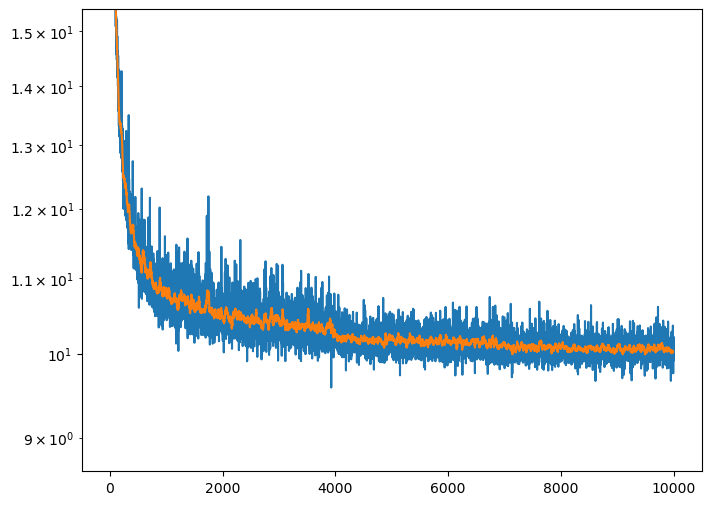

In [273]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(svi_result.losses)
ax.plot(np.arange(10, len(svi_result.losses)-10), np.convolve(svi_result.losses, [1/21]*21, mode='valid'))
ax.set(yscale='log', ylim=[np.min(svi_result.losses)*0.9, svi_result.losses[100]])
plt.show()

In [276]:
import pickle

with open("params_with_sineta_pp_2.pickle", "wb") as f:
    pickle.dump(svi_result.params, f)